# Linear classifiers: SVM and Perceptron

### Introduction: 
This is my submission for Mandatory exercise 1 on linear classifiers: SVM and Perceptron. 
I have chosen the classes Iris-setosa and Iris-versicolor, and the features petal width and sepal length.

### Perceptron:

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [81]:
dataset = pd.read_csv('iris.csv', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])
dataset = dataset[dataset['class'] != 'Iris-virginica']
dataset.drop('sepal width', axis='columns', inplace=True)
dataset.drop('petal length', axis='columns', inplace=True)
dataset.loc[dataset['class'] == 'Iris-setosa', 'class'] = 0
dataset.loc[dataset['class'] == 'Iris-versicolor', 'class'] = 1

In [82]:
# This function returns 1 if the weighted sum of inputs is non-negative, and 0 otherwise.
def sigma(x, w):
    activation = np.dot(x, w[:-1]) + w[-1]
    return 1.0 if activation >= 0 else 0.0

# The training algorithm for the Perceptron
def training(data, w0, mu, T):
    # Initialize the weights with the passed-in initial weights w0
    w = w0

    # The algorithm will iterate T times over the entire dataset
    for idx in range(T):
        # For each data point in the dataset:
        for x in data:
            # Compute the current predicted output using the activation function
            activation = sigma(x[:-1], w)
            # Calculate the error between the true label and the prediction
            error = x[-1] - activation
            # Update the bias weight based on the error
            w[-1] += mu * error
            
            # Update the feature weights based on the error
            # This is done by adding the product of the error, the learning rate, and the feature value
            for i in range(len(x) - 1):
                w[i] += mu * error * x[i]

    # Return the final learned weights after T iterations
    return w

features = dataset[['petal width', 'sepal length']].values
labels = dataset['class'].values.astype(float)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

data_train = np.c_[X_train, y_train]

weights = np.random.rand(3)  # Random initialization
weights = training(data_train, weights, 0.2, 15)

print(f"Final weights: {weights}")

Final weights: [ 3.48427213 -0.44695718 -0.49072459]


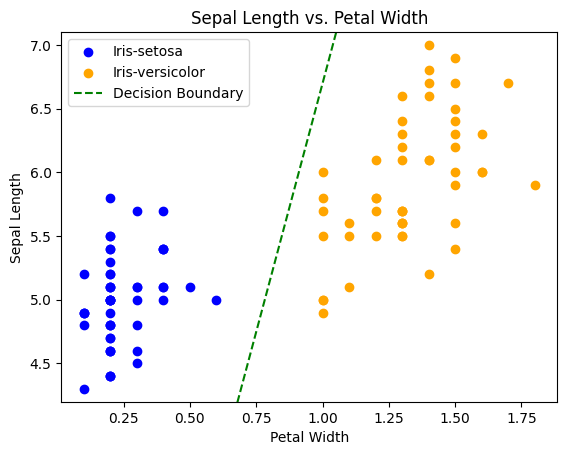

In [83]:
colors = ['blue', 'orange']
labels = [0, 1]
species_name = ['Iris-setosa', 'Iris-versicolor']

for label, color, name in zip(labels, colors, species_name):
    subset = dataset[dataset['class'] == label]
    plt.scatter(subset['petal width'], subset['sepal length'], color=color, label=name)

# Plotting the decision boundary using the final weights
x_values = np.linspace(dataset['petal width'].min(), dataset['petal width'].max(), 100)
y_values = (-weights[0] * x_values - weights[2]) / weights[1]
plt.plot(x_values, y_values, 'g--', label='Decision Boundary')

plt.xlabel('Petal Width')
plt.ylabel('Sepal Length')
plt.legend(loc='upper left')
plt.title('Sepal Length vs. Petal Width')
plt.ylim(dataset['sepal length'].min() -0.1, dataset['sepal length'].max()+0.1)
plt.show()

### SVM 
In this section, I will adapt the SVM code from https://github.com/krayyalasomayajula/DTE2502/tree/main/SVM_code on the Iris dataset

In [84]:
class SVM:
    def __init__(self, learning_rate=1e-3, lambda_param=1e-3, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def _init_weights_bias(self, X):
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.b = 0

    def _get_cls_map(self, y):
        return np.where(y <= 0, -1, 1)

    def _satisfy_constraint(self, x, idx):
        linear_model = np.dot(x, self.w) + self.b 
        return self.cls_map[idx] * linear_model >= 1
    
    def _get_gradients(self, constrain, x, idx):
        if constrain:
            dw = self.lambda_param * self.w
            db = 0
            return dw, db
        
        dw = self.lambda_param * self.w - np.dot(self.cls_map[idx], x)
        db = - self.cls_map[idx]
        return dw, db
    
    def _update_weights_bias(self, dw, db):
        self.w -= self.lr * dw
        self.b -= self.lr * db
    
    def fit(self, X, y):
        self._init_weights_bias(X)
        self.cls_map = self._get_cls_map(y)

        for _ in range(self.n_iters):
            for idx, x in enumerate(X):
                constrain = self._satisfy_constraint(x, idx)
                dw, db = self._get_gradients(constrain, x, idx)
                self._update_weights_bias(dw, db)
    
    def predict(self, X):
        estimate = np.dot(X, self.w) + self.b
        prediction = np.sign(estimate)
        return np.where(prediction == -1, 0, 1)

In [85]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

def get_hyperplane(x, w, b, offset):
    return (-w[0] * x - b + offset) / w[1]

In [86]:
# Splitting the data into train and test
features = dataset[['petal width', 'sepal length']].values
labels = dataset['class'].values.astype(int)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Training the SVM model
clf = SVM()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

# Printing the accuracy
print("SVM Accuracy:", accuracy(y_test, predictions))

SVM Accuracy: 1.0


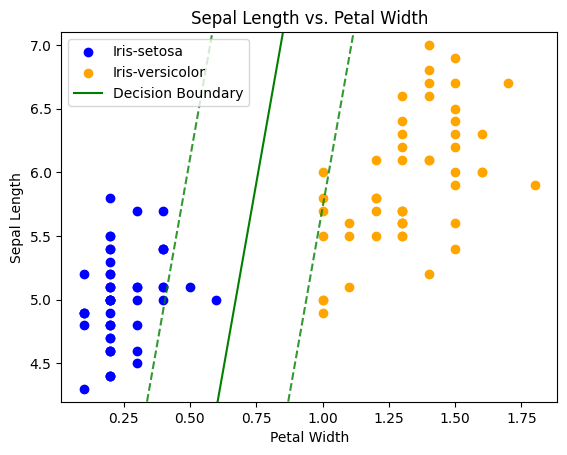

In [87]:
colors = ['blue', 'orange']
labels = [0, 1]

for label, color, name in zip(labels, colors, species_names):
    subset = dataset[dataset['class'] == label]
    plt.scatter(subset['petal width'], subset['sepal length'], color=color, label=name)

# Plotting the decision boundary using the SVM weights
x_values = np.linspace(dataset['petal width'].min(), dataset['petal width'].max(), 100)

# Decision Boundary
y_values = get_hyperplane(x_values, clf.w, clf.b, 0)
plt.plot(x_values, y_values, 'g-', label='Decision Boundary')

# Margins
y_values_margin_positive = get_hyperplane(x_values, clf.w, clf.b, 1)
y_values_margin_negative = get_hyperplane(x_values, clf.w, clf.b, -1)
plt.plot(x_values, y_values_margin_positive, 'g--', alpha=0.8)
plt.plot(x_values, y_values_margin_negative, 'g--', alpha=0.8)

plt.xlabel('Petal Width')
plt.ylabel('Sepal Length')
plt.legend(loc='upper left')
plt.title('Sepal Length vs. Petal Width')
plt.ylim(dataset['sepal length'].min() -0.1, dataset['sepal length'].max()+0.1)
plt.show()

### Different method SVM
I will now plot different SVM classifiers in the iris dataset, using the example on https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html

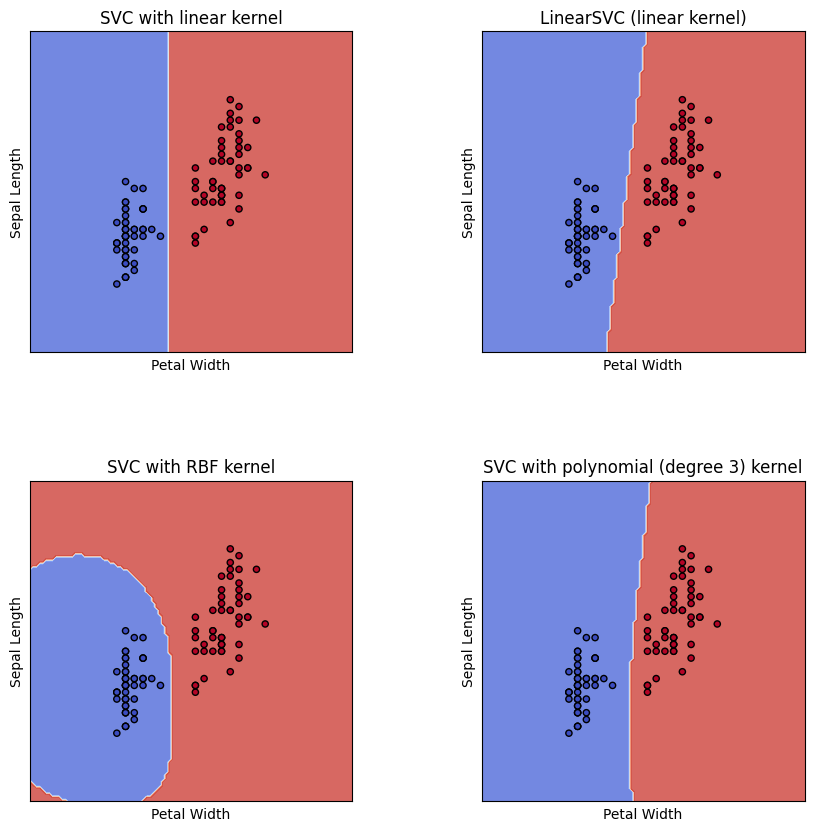

In [88]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

X = dataset[['petal width', 'sepal length']].values
y = dataset['class'].values.astype(int)

# SVM Model Training
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel="linear", C=C),
          svm.LinearSVC(C=C, max_iter=10000, dual="auto"),
          svm.SVC(kernel="rbf", gamma=0.7, C=C),
          svm.SVC(kernel="poly", degree=3, gamma="auto", C=C))
models = (clf.fit(X, y) for clf in models)

# Titles for the plots
titles = ("SVC with linear kernel",
          "LinearSVC (linear kernel)",
          "SVC with RBF kernel",
          "SVC with polynomial (degree 3) kernel")

# Visualization
fig, sub = plt.subplots(2, 2, figsize=(10,10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        ax=ax,
        alpha=0.8,
        xlabel='Petal Width',
        ylabel='Sepal Length'
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

### SVM with all features 

In [89]:
# Reload the dataset with all features
dataset_full = pd.read_csv('iris.csv', header=None, names=['sepal length', 'sepal width', 'petal length', 'petal width', 'class'])

dataset_full = dataset_full[dataset_full['class'] != 'Iris-virginica']

dataset_full.loc[dataset_full['class'] == 'Iris-setosa', 'class'] = 0
dataset_full.loc[dataset_full['class'] == 'Iris-versicolor', 'class'] = 1

# Use all four features for training
features = dataset_full[['sepal length', 'sepal width', 'petal length', 'petal width']].values
labels = dataset_full['class'].values.astype(int)

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Training the SVM model
clf = SVM()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

# Printing the accuracy
print("SVM Accuracy:", accuracy(y_test, predictions))

SVM Accuracy: 1.0


### Observable results
The SVM seems to have more stable results than the perceptron. It has fewer parameters that needs tuning. 
The Prceptron is more straightforward, but might converge to non-optimal solution. It is more sensitive to initial conditions, that can potentially lead to varied results.